In [166]:
from dotenv import load_dotenv
from langchain import hub
from langchain_community.chat_models import ChatOllama
from langgraph.graph import END, StateGraph
from typing import Dict, TypedDict
from langchain.prompts import PromptTemplate
import pprint
import os

Local LLM Setup with OpenAI-compatible 

In [167]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3",
    base_url="http://localhost:11434/v1",
    temperature=0
)

Tool Set-up (Tavili Search Results)

In [168]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3,tavily_api_key=os.environ['TAVILY_API_KEY'])
tools = [tool]
#tool.invoke("Jenny Lee Granite")

In [169]:
def generate_tool_schema(tools: list) -> str:
    if tools == []: return ""
    res = "You may use the following tools: \n"
    for tool in tools:
        res += "{"
        res += "tool_name: " + tool.name  + "\n"
        res += "description: " + tool.description + "\n"
        res += "}\n"
    return res

In [170]:
print(generate_tool_schema(tools))

You may use the following tools: 
{tool_name: tavily_search_results_json
description: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
}



In [171]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
#llm_with_tools = llm.bind_tools(tools)

In [172]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [173]:
EXTRACTION_PROMPT = "Extract the JSON object from the preceding message. Return only the JSON object and nothing else."

def json_extractor(state: State):
    print(state)
    return {"messages": [llm.invoke(state["messages"])]}
    #return {"messages": [llm.invoke(state["messages"][-1].content) + EXTRACTION_PROMPT]}

graph_builder.add_node("json_extractor", json_extractor)

In [174]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Routing Setup

In [175]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print("\n --- \n calling tools\n ---")
        return "tools"
    print("\n --- \n not calling tools\n ---")
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "json_extractor",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("chatbot", "json_extractor")
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

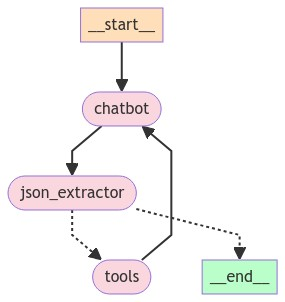

In [176]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [177]:
TOOL_PROMPT = """
If you need to use a tool, return only an json object with tool_calls as an attribute. 
For example: 
{
  "tool_calls": [
    {
      "id": "id_value",
      "function": {
        "args": '{"arg_name": "arg_value"}',
        "name": "tool_name"
      },
      "type": "function"
    }
  ]
}
"""

In [178]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    user_input += generate_tool_schema(tools)
    user_input += TOOL_PROMPT
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1]):
                print("Assistant:", value["messages"][-1].content)

Assistant: Here is the search result for Lee Hsien Loong:

{
  "tool_calls": [
    {
      "id": "tavily_search_results_json",
      "function": {
        "args": '{"query": "Lee Hsien Loong"}',
        "name": "tavily_search_results_json"
      },
      "type": "function"
    }
  ]
}

Note: Lee Hsien Loong is the current Prime Minister of Singapore, serving since 2004.
{'messages': [HumanMessage(content='Search for Lee Hsien loongYou may use the following tools: \n{tool_name: tavily_search_results_json\ndescription: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.\n}\n\nIf you need to use a tool, return only an json object with tool_calls as an attribute. \nFor example: \n{\n  "tool_calls": [\n    {\n      "id": "id_value",\n      "function": {\n        "args": \'{"arg_name": "arg_value"}\',\n        "name": "tool_name"\n      },\n      "type": "function"\n    